In [ ]:
# Install all prerequisites
%pip install -r ../requirements.txt

# Dataset preparation

In [ ]:
# Define URLs and download/extract paths
url = "https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/zw4p4p7sdh-1.zip"
zipfile_path = "../data/raw/" + url.split("/")[-1]
extract_path = "../data/external/"

In [ ]:
import requests
from tqdm import tqdm

# Download the dataset
response = requests.get(url, stream = True)
with open(zipfile_path, "wb") as handle:
  for data in tqdm(response.iter_content(), total = int(response.headers['Content-Length'])):
    handle.write(data)

In [ ]:
from zipfile import ZipFile

# Extract the dataset
with ZipFile(zipfile_path, "r") as handle:
  handle.extractall(extract_path)

# Feature extraction

In [ ]:
import os

# Set dataset path and inspect
extract_path = "../data/external/"
dataset_path = extract_path + "".join(url.split("/")[-1].split(".")[:-1]) + "/"
os.walk(dataset_path)

In [ ]:
import pandas as pd

# Import and inspect speakers metadata
speakers = pd.read_csv(dataset_path + "speakers.csv")
speakers

In [ ]:
# speakers.csv is padded with redundant lines, remove
speakers.dropna(axis = 0, how = "all", inplace = True)
speakers.dropna(axis = 1, how = "all", inplace = True)

# Convert ID to int and set as index
speakers.set_index(speakers["ID"].astype(int), inplace = True)
speakers.drop("ID", axis = 1, inplace = True)

# Save modified metadata
feature_path = "../data/processed/"
speakers.to_csv(feature_path + "speakers.csv")
speakers

In [ ]:
import librosa
import numpy as np
from glob import glob

sample_rate = 48000
duration = 3
spectrograms = []

# Glob FLAC files
for id in tqdm(speakers.index):
  if not os.path.exists(feature_path + str(id)):
    os.mkdir(feature_path + str(id))

  for audio_file in glob(dataset_path + "*/" + str(id) + "/*.flac"):
    # Generate log mel spectrogram
    audio = librosa.load(audio_file, sr = sample_rate, duration = duration)[0].copy()
    audio.resize(sample_rate * duration)
    spec = librosa.feature.melspectrogram(y = audio, sr = sample_rate)
    spec = librosa.power_to_db(spec, ref = np.max)
    spec = (spec - spec.mean()) / spec.std()
    spec = (spec - spec.min()) / (spec.max() - spec.min())

    # Save as .npy
    np.save(feature_path + str(id) + "/" + "".join(audio_file.split("/")[-1].split(".")[:-1]) + ".npy", spec)

# Training

In [2]:
import pandas as pd

# Load speakers.csv
feature_path = "../data/processed/"
speakers = pd.read_csv(feature_path + "speakers.csv", index_col = 0)
speakers

,Gender,Age,Weight,Height
ID,,,,
1,f,43.0,85.0,166.0
2,f,13.0,50.0,158.0
3,m,9.0,32.0,134.0
4,f,22.0,58.0,162.0
5,f,18.0,63.0,168.0
...,...,...,...,...
146,f,25.0,60.0,166.0
147,f,22.0,65.0,161.0
148,f,27.0,55.0,150.0


In [4]:
import numpy as np
import tensorflow as tf
from glob import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm

test_size = 0.1
random_state = 0
X, y_gender, y_age = [], [], []

# Load features from NumPy caches
for id in tqdm(speakers.index):
  for feature_file in glob(feature_path + str(id) + "/*.npy"):
    X.append(np.load(feature_file))
    y_gender.append(speakers["Gender"][id] == "m")
    y_age.append(int(speakers["Age"][id]))

# Prepare features and targets
X, y_gender, y_age = np.array(X), tf.keras.utils.to_categorical(y_gender, num_classes = len(set(y_gender))), np.array(y_age)
X = X.reshape(X.shape + (1,))
X_train, X_test, y_gender_train, y_gender_test, y_age_train, y_age_test = train_test_split(X, y_gender, y_age, test_size = 0.1, random_state = 0)
X.shape

100%|██████████| 150/150 [00:02<00:00, 62.28it/s]


(3000, 128, 282, 1)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D

batch = 8
epochs = 30
val_size = 0.1

# Make and fit gender classification model
model_gender = Sequential([
  Input(X.shape[1:]),
  Conv2D(16, (3, 3), activation = "relu"),
  MaxPooling2D((2, 2)),
  Conv2D(32, (3, 3), activation = "relu"),
  MaxPooling2D((2, 2)),
  Conv2D(64, (3, 3), activation = "relu"),
  MaxPooling2D((2, 2)),
  Dropout(0.5),
  Flatten(),
  Dense(64, activation = "relu"),
  Dense(2, activation = "softmax")
])
model_gender.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
history_gender = model_gender.fit(X_train, y_gender_train, batch_size = batch, epochs = epochs, validation_split = val_size)

2022-06-01 23:39:24.096558: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-06-01 23:39:24.096603: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: sy3c4ll-tfg266
2022-06-01 23:39:24.096611: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: sy3c4ll-tfg266
2022-06-01 23:39:24.096756: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.73.5
2022-06-01 23:39:24.096782: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.73.5
2022-06-01 23:39:24.096787: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.73.5
2022-06-01 23:39:24.097089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance

Epoch 1/30


2022-06-01 23:39:24.208833: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 350853120 exceeds 10% of free system memory.


304/304 [==============================] - ETA: 0s - loss: 0.3843 - accuracy: 0.8391

2022-06-01 23:39:59.771988: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 38983680 exceeds 10% of free system memory.


304/304 [==============================] - 36s 117ms/step - loss: 0.3843 - accuracy: 0.8391 - val_loss: 0.1281 - val_accuracy: 0.9778
Epoch 2/30
304/304 [==============================] - 36s 118ms/step - loss: 0.1590 - accuracy: 0.9477 - val_loss: 0.0855 - val_accuracy: 0.9741
Epoch 3/30
304/304 [==============================] - 35s 115ms/step - loss: 0.1087 - accuracy: 0.9638 - val_loss: 0.0678 - val_accuracy: 0.9815
Epoch 4/30
304/304 [==============================] - 35s 115ms/step - loss: 0.0769 - accuracy: 0.9716 - val_loss: 0.0726 - val_accuracy: 0.9741
Epoch 5/30
304/304 [==============================] - 34s 113ms/step - loss: 0.0519 - accuracy: 0.9815 - val_loss: 0.0398 - val_accuracy: 0.9815
Epoch 6/30
304/304 [==============================] - 35s 114ms/step - loss: 0.0459 - accuracy: 0.9844 - val_loss: 0.0423 - val_accuracy: 0.9852
Epoch 7/30
304/304 [==============================] - 35s 115ms/step - loss: 0.0347 - accuracy: 0.9893 - val_loss: 0.0417 - val_accuracy: 0.9

In [12]:
# Make and fit age regression model
model_age = Sequential([
  Input(X.shape[1:]),
  Conv2D(16, (3, 3), activation = "relu"),
  MaxPooling2D((2, 2)),
  Conv2D(32, (3, 3), activation = "relu"),
  MaxPooling2D((2, 2)),
  Conv2D(64, (3, 3), activation = "relu"),
  MaxPooling2D((2, 2)),
  Dropout(0.5),
  Flatten(),
  Dense(64, activation = "relu"),
  Dense(1)
])
model_age.compile(loss = "mean_absolute_error", optimizer = "adam", metrics = ["mean_absolute_error"])
history_age = model_age.fit(X_train, y_age_train, batch_size = batch, epochs = epochs, validation_split = val_size)

Epoch 1/30
304/304 [==============================] - 30s 98ms/step - loss: 4.2378 - mean_absolute_error: 4.2378 - val_loss: 3.1273 - val_mean_absolute_error: 3.1273
Epoch 2/30
304/304 [==============================] - 35s 114ms/step - loss: 3.4224 - mean_absolute_error: 3.4224 - val_loss: 2.6209 - val_mean_absolute_error: 2.6209
Epoch 3/30
304/304 [==============================] - 34s 112ms/step - loss: 3.3878 - mean_absolute_error: 3.3878 - val_loss: 2.5661 - val_mean_absolute_error: 2.5661
Epoch 4/30
304/304 [==============================] - 33s 109ms/step - loss: 3.2400 - mean_absolute_error: 3.2400 - val_loss: 2.9313 - val_mean_absolute_error: 2.9313
Epoch 5/30
304/304 [==============================] - 40s 131ms/step - loss: 3.2432 - mean_absolute_error: 3.2432 - val_loss: 2.5459 - val_mean_absolute_error: 2.5459
Epoch 6/30
304/304 [==============================] - 36s 119ms/step - loss: 3.1132 - mean_absolute_error: 3.1132 - val_loss: 2.5977 - val_mean_absolute_error: 2.5977

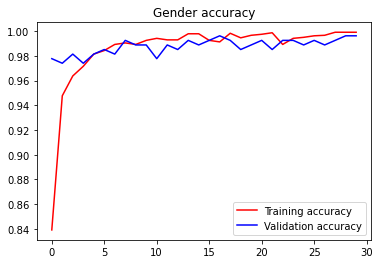

<Figure size 432x288 with 0 Axes>

 3/10 [========>.....................] - ETA: 0s - loss: 0.1363 - accuracy: 0.9792

2022-06-02 01:00:09.777453: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 72253440 exceeds 10% of free system memory.


10/10 [==============================] - 1s 63ms/step - loss: 0.0599 - accuracy: 0.9833


0.9833333492279053

In [9]:
import matplotlib.pyplot as plt

# Display accuracy metrics for gender classification model
plt.plot(range(epochs), history_gender.history["accuracy"], "r", label = "Training accuracy")
plt.plot(range(epochs), history_gender.history["val_accuracy"], "b", label = "Validation accuracy")
plt.title("Gender accuracy")
plt.legend(loc = 0)
plt.figure()
plt.show()

loss_gender, acc_gender = model_gender.evaluate(X_test, y_gender_test)
acc_gender

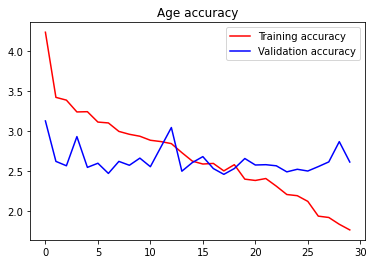

<Figure size 432x288 with 0 Axes>

10/10 [==============================] - 1s 67ms/step - loss: 2.4565 - mean_absolute_error: 2.4565


2.4565162658691406

In [14]:
# Display accuracy metrics for age regression model
plt.plot(range(epochs), history_age.history["mean_absolute_error"], "r", label = "Training accuracy")
plt.plot(range(epochs), history_age.history["val_mean_absolute_error"], "b", label = "Validation accuracy")
plt.title("Age accuracy")
plt.legend(loc = 0)
plt.figure()
plt.show()

loss_age, acc_age = model_age.evaluate(X_test, y_age_test)
acc_age

In [15]:
model_path = "../models/"

# Save models as HDF5
model_gender.save(model_path + "gender.h5")
model_age.save(model_path + "age.h5")

# Predicting

In [17]:
from tensorflow.keras.models import load_model

# Load models from HDF5
model_path = "../models/"
model_gender = load_model(model_path + "gender.h5")
model_age = load_model(model_path + "age.h5")

In [45]:
import librosa
import numpy as np
from glob import glob

target = glob("../data/external/*/*/*/*.flac")[0]
sample_rate = 48000
duration = 3

# Prepare target
audio = librosa.load(target, sr = sample_rate, duration = duration)[0].copy()
audio.resize(sample_rate * duration)
spec = librosa.feature.melspectrogram(y = audio, sr = sample_rate)
spec = librosa.power_to_db(spec, ref = np.max)
spec = (spec - spec.mean()) / spec.std()
spec = (spec - spec.min()) / (spec.max() - spec.min())
spec = spec.reshape((1,) + spec.shape + (1,))

target

'../data/external/zw4p4p7sdh-1/differentPhrase/1/1-12.flac'

In [46]:
# Compute predictions
gender = model_gender.predict(spec)[0]
age = model_age.predict(spec)[0]
gender, age

1/1 [==============================] - 0s 39ms/step


(array([9.999999e-01, 7.862037e-08], dtype=float32),
 array([36.851074], dtype=float32))

In [47]:
# Interpret results
print("Gender:\t" + ("m" if np.argmax(gender) else "f"))
print("Age:\t" + str(age[0]))

Gender:	f
Age:	36.851074
